In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
from scipy import stats
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import shapiro,norm
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
import re

import statsmodels.stats as sms
import statsmodels.stats.api as sm
from statsmodels.api import qqplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,roc_auc_score,roc_curve
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Read Data

In [68]:
data=pd.read_csv("final_kentron_sale.csv",encoding="latin_1")

In [69]:
data.head()

,Unnamed: 0,Air_conditioner,Balcony,Central_Heating,Close_bus_station,Electricity,Equipment,Euro_windows,Furniture,Gas,...,Metro,Nightclub,Pub,Restaurants,School,Secondary_highway,Supermarket,University,Republick_square,Opera_house
0,0,0,0,0,1,1,1,1,1,1,...,3082,3809,2727,390,114,505,400,2320,5524.202772,4727.800809
1,1,1,0,0,1,1,1,1,1,1,...,544,309,151,35,58,248,78,451,318.650969,866.417523
2,2,1,0,1,0,1,1,0,1,1,...,568,341,316,54,453,39,186,406,851.817719,1047.418623
3,3,0,0,0,1,1,0,1,0,1,...,483,1348,2084,169,346,317,81,388,3080.457397,2465.234661
4,4,1,0,1,1,1,0,1,1,1,...,1511,1850,1745,398,732,612,246,1707,3510.044212,2690.342808


## Preparing Data

In [22]:
data = data[data.city=="Yerevan"] # taking only Yerevan as there are a few ones from other cities

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5437 entries, 0 to 5448
Data columns (total 67 columns):
Unnamed: 0           5437 non-null int64
Air_conditioner      5437 non-null int64
Balcony              5437 non-null int64
Central_Heating      5437 non-null int64
Close_bus_station    5437 non-null int64
Electricity          5437 non-null int64
Equipment            5437 non-null int64
Euro_windows         5437 non-null int64
Furniture            5437 non-null int64
Gas                  5437 non-null int64
Heated_Floor         5437 non-null int64
Heating              5437 non-null int64
Hot_water            5437 non-null int64
Id                   5437 non-null object
Internet             5437 non-null int64
Irrigation           5437 non-null int64
Laminate_flooring    5437 non-null int64
Open_balcony         5437 non-null int64
Parking              5437 non-null int64
Parquet              5437 non-null int64
Playground           5437 non-null int64
Security_system      5437 non-n

In [24]:
categoricals=['Air_conditioner', 'Central_Heating', 'Close_bus_station',
       'Electricity', 'Equipment', 'Euro_windows', 'Furniture', 'Gas',
       'Heated_Floor', 'Heating', 'Hot_water','Internet', 'Irrigation',
       'Laminate_flooring', 'Open_balcony', 'Parking', 'Parquet', 'Playground',
       'Security_system', 'Sewerage', 'Standing_water', 'Sunny','View',
       'Swimming_pool', 'Tile', 'Water','new_construction','sold',"floor","building_floors"]

In [25]:
for i in categoricals:
    data[i]=data[i].astype("category")

#### Droping unnessary columns

In [26]:
data.drop(["Unnamed: 0","city","Balcony","info","Id","date",'sold'],axis=1,inplace=True) 

### Normalizing Price variable

### Solving outliers problem and Normalizing features

In [27]:
data.floor=data.floor.replace("Basement",0,regex=True)
data.floor=pd.to_numeric(data["floor"])
data.bathrooms=data.bathrooms.replace("5+",5,regex=True)
data.rooms=data.rooms.astype("object")
#data.bathrooms=pd.to_numeric(data["bathrooms"])           if we keep it as categorical

In [28]:
def outliers_IQR(data, col):
    lower_quartile = data[col].quantile(0.05)
    upper_quartile = data[col].quantile(0.95)
    IQR = upper_quartile - lower_quartile
    outlier_thresh = 1.5 * IQR
    return data[data[col].between((lower_quartile - outlier_thresh), (upper_quartile + outlier_thresh))]

In [29]:
data_numeric= data.select_dtypes(include="number")
data_object=data.select_dtypes(exclude='number')
data_numeric.columns

Index(['area', 'floor', 'latitude', 'longitude', 'price', 'views', 'Hospital',
       'Primary_highway', 'ATM', 'Bank', 'Bar', 'Bus_stop', 'Café', 'College',
       'kindergarden', 'Metro', 'Nightclub', 'Pub', 'Restaurants', 'School',
       'Secondary_highway', 'Supermarket', 'University', 'Republick_square',
       'Opera_house'],
      dtype='object')

In [30]:
data_numeric.var()==0

area                 False
floor                False
latitude             False
longitude            False
price                False
views                False
Hospital             False
Primary_highway      False
ATM                  False
Bank                 False
Bar                  False
Bus_stop             False
Café                 False
College              False
kindergarden         False
Metro                False
Nightclub            False
Pub                  False
Restaurants          False
School               False
Secondary_highway    False
Supermarket          False
University           False
Republick_square     False
Opera_house          False
dtype: bool

In [32]:
data_numeric.shape

(5289, 25)


 mu = 90.39 and sigma = 39.94



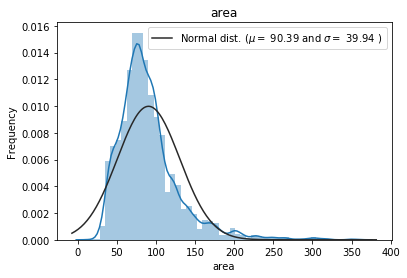

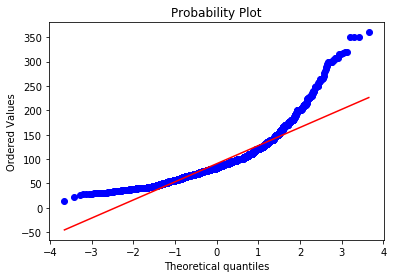


 mu = 5.44 and sigma = 3.61



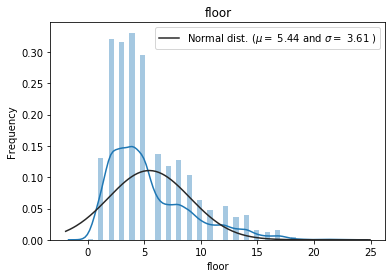

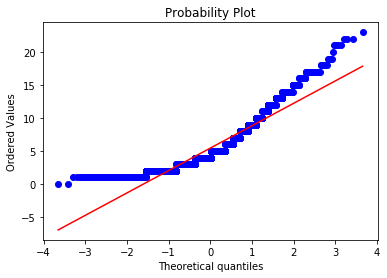


 mu = 40.19 and sigma = 0.02



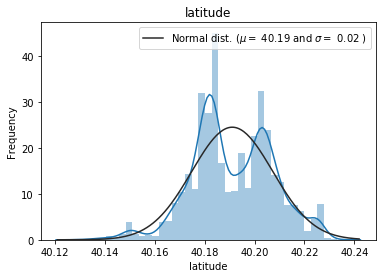

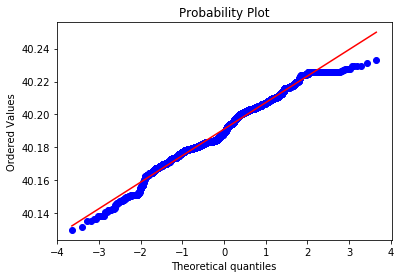


 mu = 44.51 and sigma = 0.02



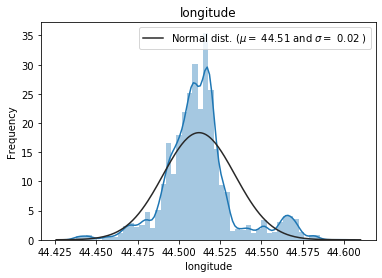

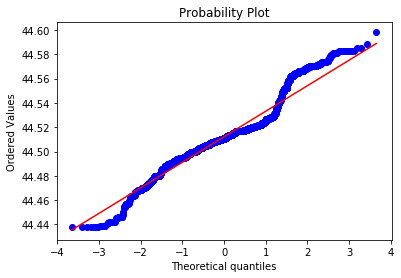


 mu = 139652.25 and sigma = 104579.89



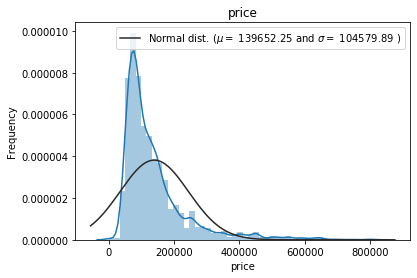

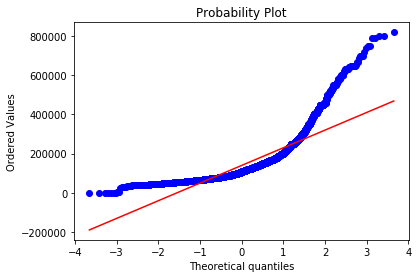


 mu = 440.98 and sigma = 396.62



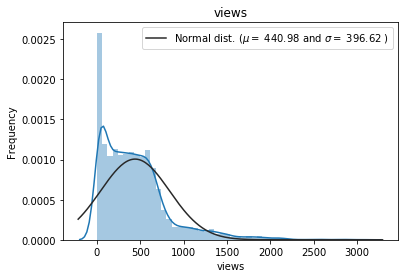

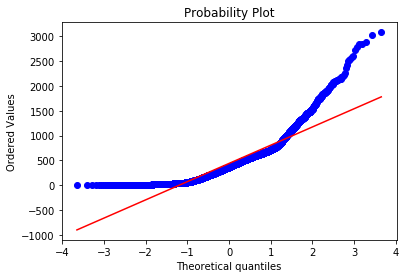


 mu = 566.58 and sigma = 415.55



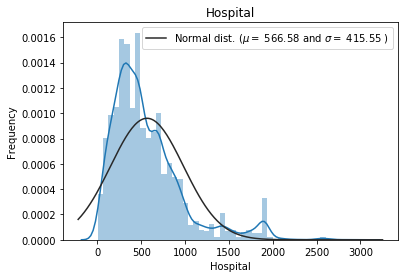

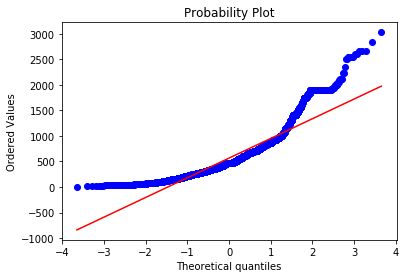


 mu = 314.77 and sigma = 330.87



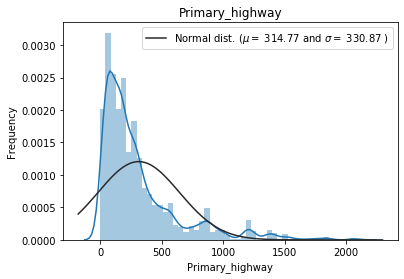

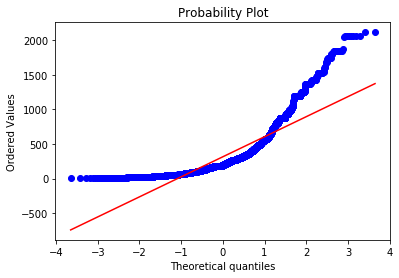


 mu = 187.31 and sigma = 159.98



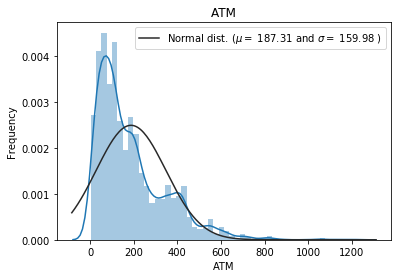

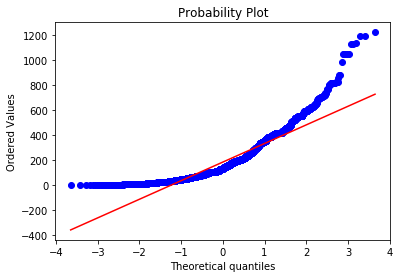


 mu = 230.47 and sigma = 198.23



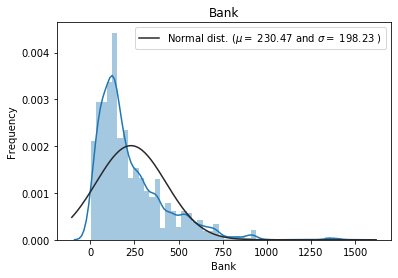

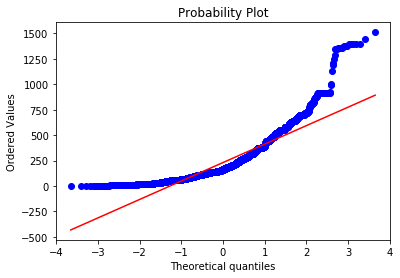


 mu = 679.61 and sigma = 685.48



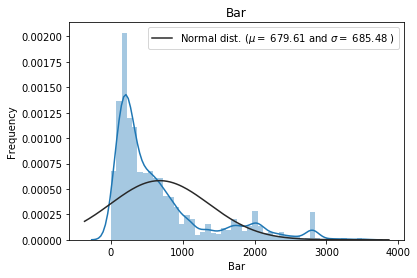

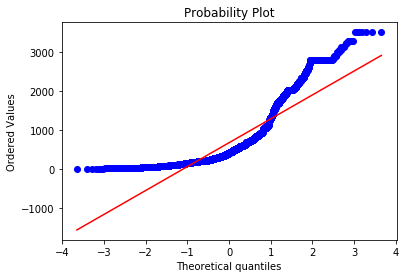


 mu = 181.18 and sigma = 147.48



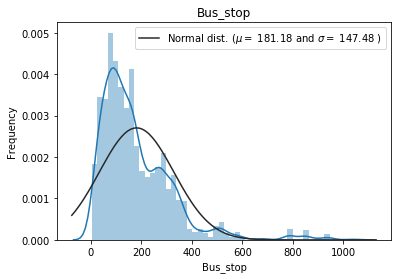

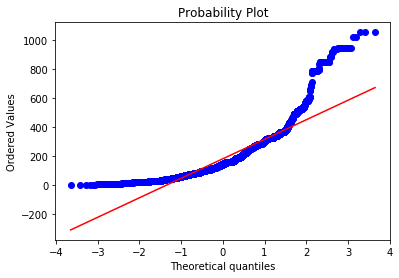


 mu = 385.28 and sigma = 435.43



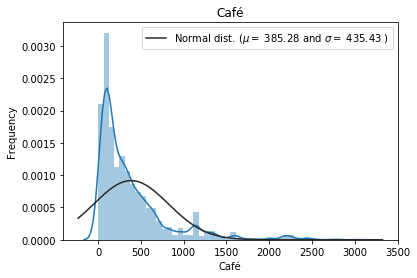

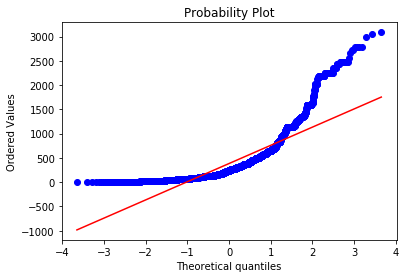


 mu = 928.17 and sigma = 570.27



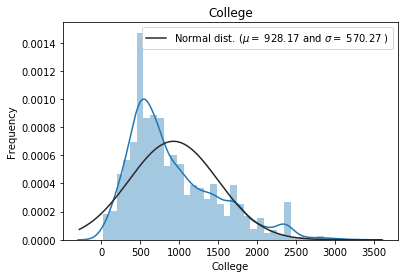

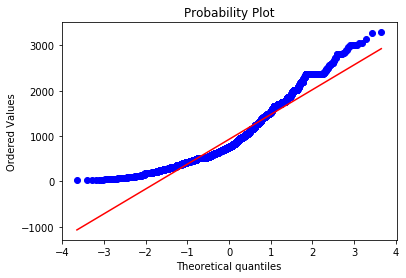


 mu = 425.85 and sigma = 259.39



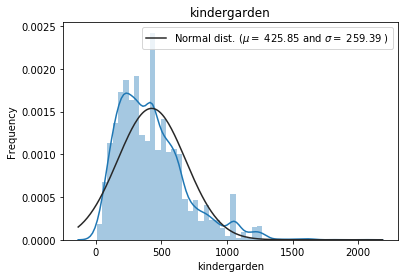

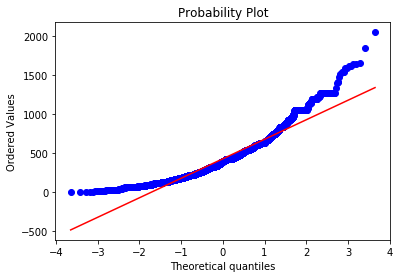


 mu = 1336.14 and sigma = 1228.10



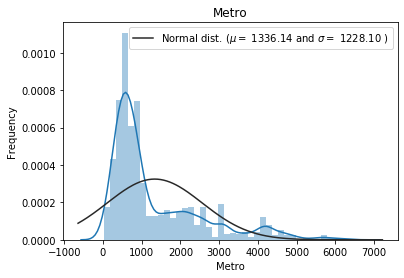

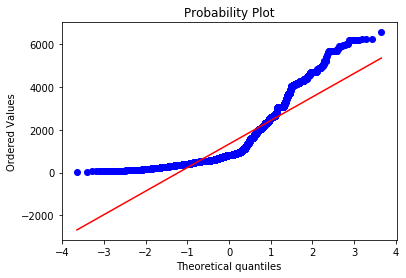


 mu = 971.86 and sigma = 942.55



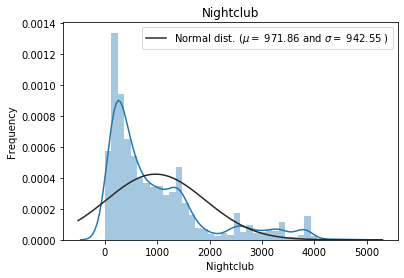

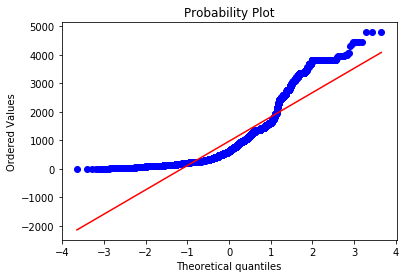


 mu = 1123.21 and sigma = 919.06



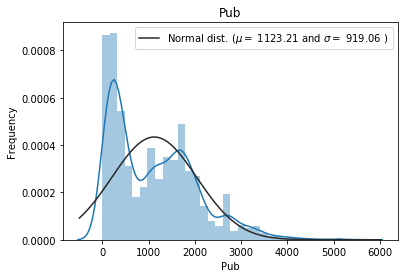

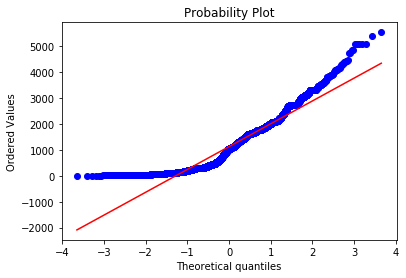


 mu = 228.95 and sigma = 204.50



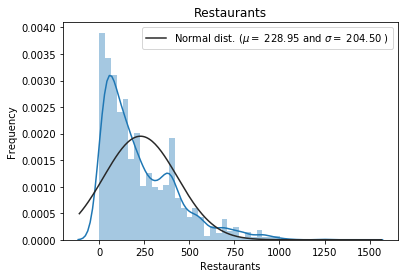

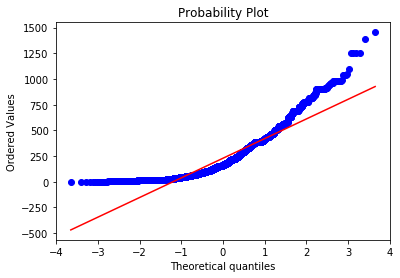


 mu = 310.50 and sigma = 224.19



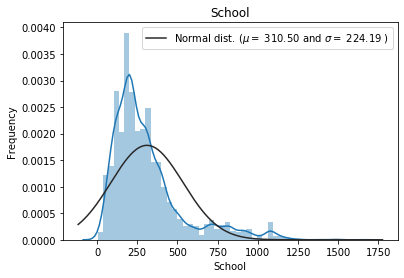

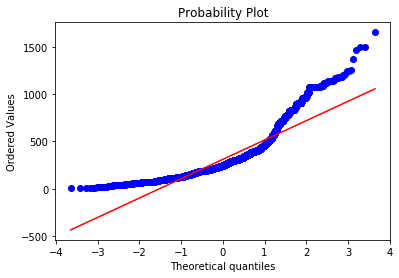


 mu = 337.19 and sigma = 296.79



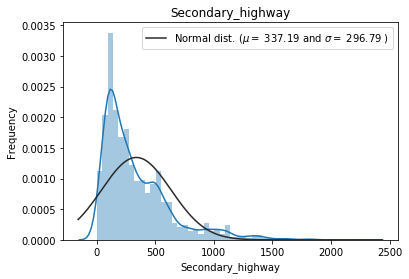

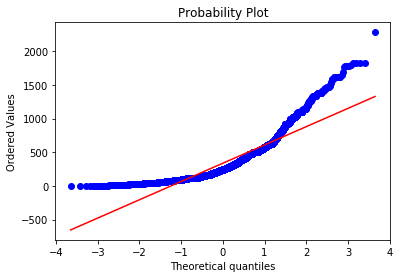


 mu = 227.63 and sigma = 173.39



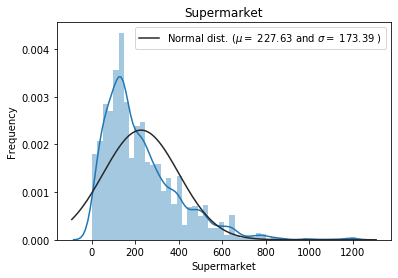

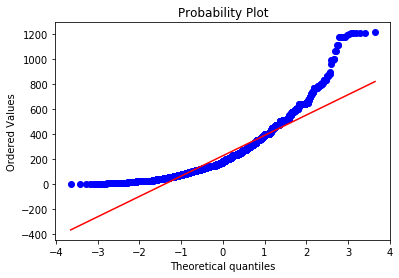


 mu = 801.32 and sigma = 742.12



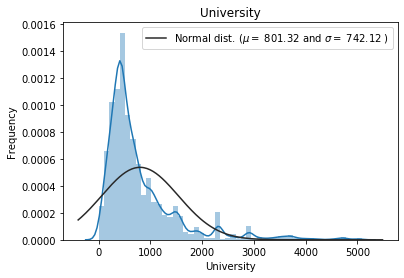

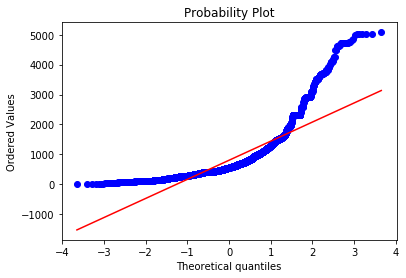


 mu = 2437.36 and sigma = 1718.40



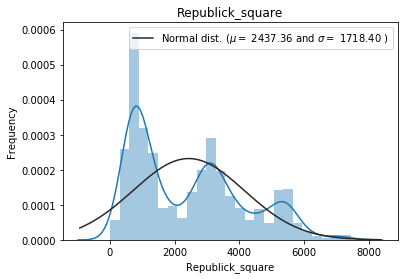

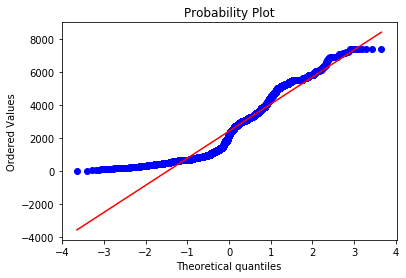


 mu = 2180.66 and sigma = 1522.97



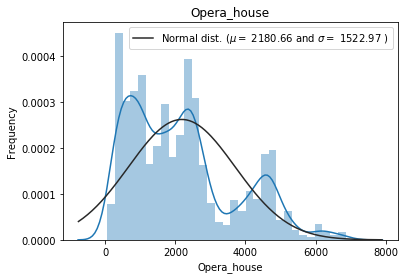

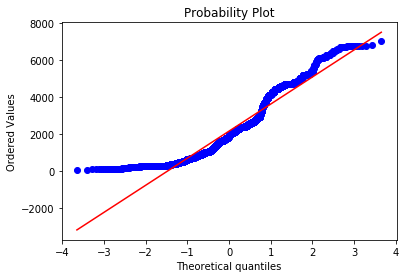

In [33]:
for i in data_numeric.columns:
    sns.distplot(data_numeric[i] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data_numeric[i])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title(i)

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data_numeric[i], plot=plt)
    plt.show()


 mu = 4.43 and sigma = 0.39



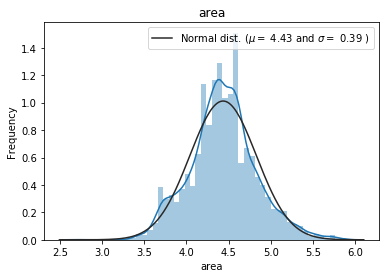

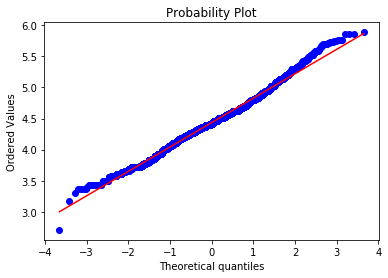


 mu = 1.72 and sigma = 0.54



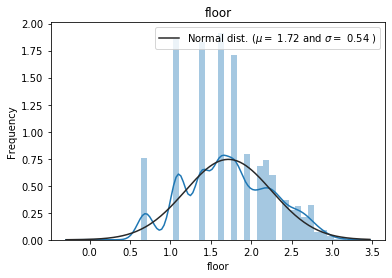

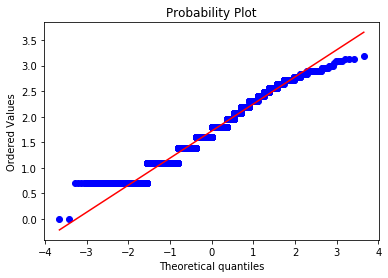


 mu = 3.72 and sigma = 0.00



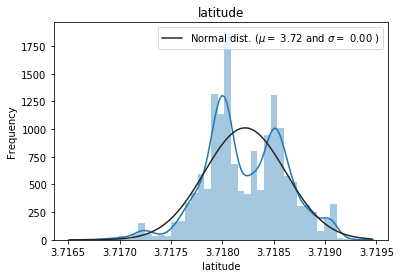

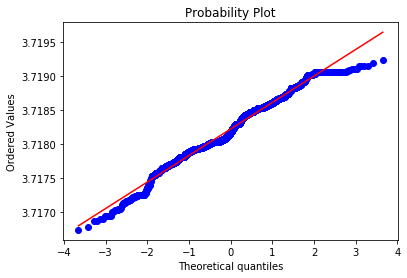


 mu = 3.82 and sigma = 0.00



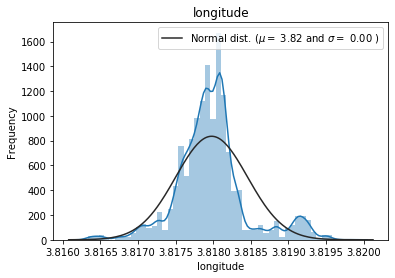

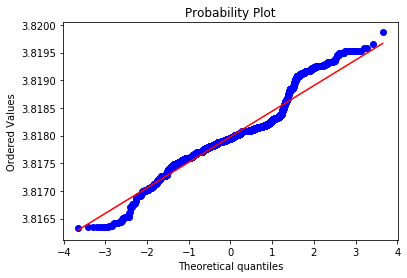


 mu = 11.65 and sigma = 0.61



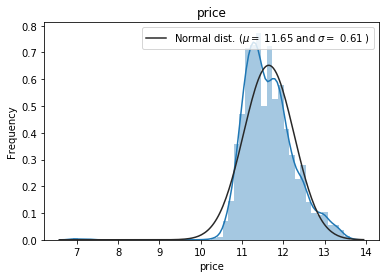

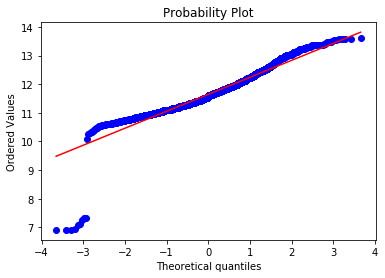


 mu = 5.57 and sigma = 1.24



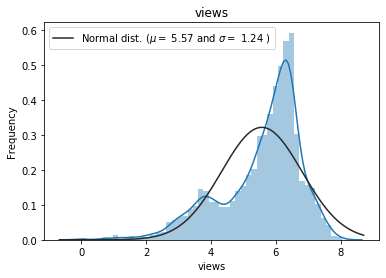

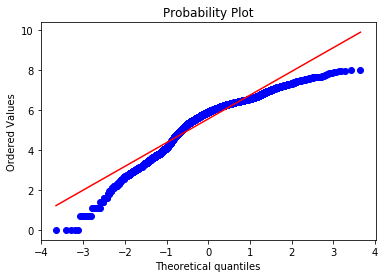


 mu = 6.08 and sigma = 0.77



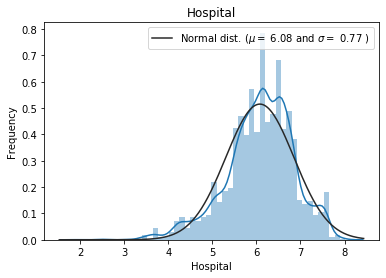

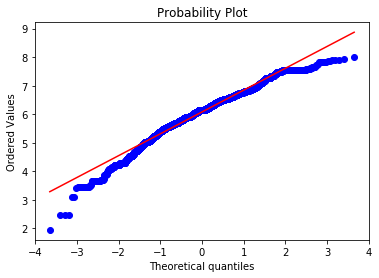


 mu = 5.26 and sigma = 1.06



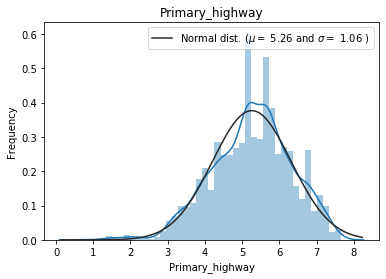

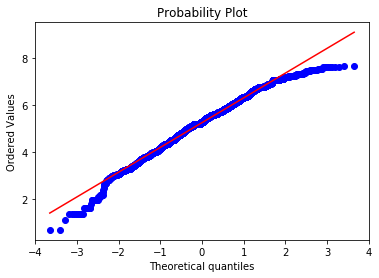


 mu = 4.85 and sigma = 0.97



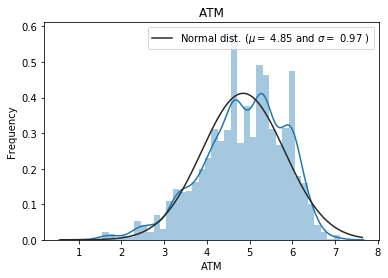

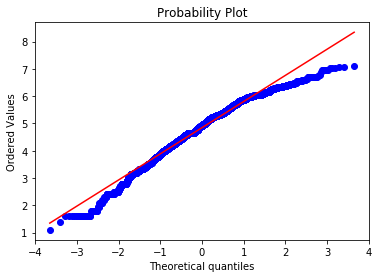


 mu = 5.08 and sigma = 0.93



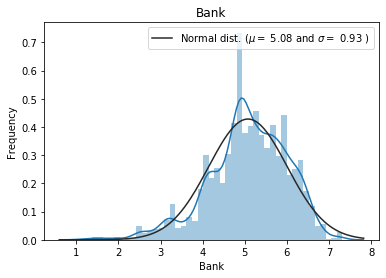

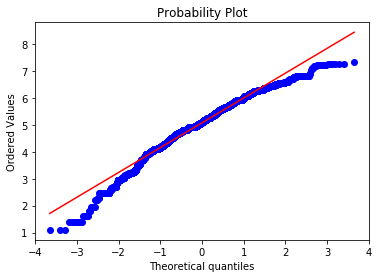


 mu = 6.04 and sigma = 1.02



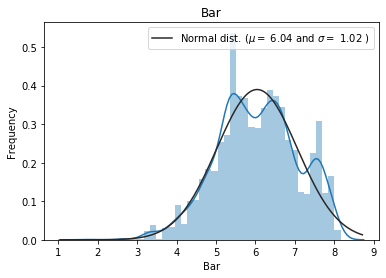

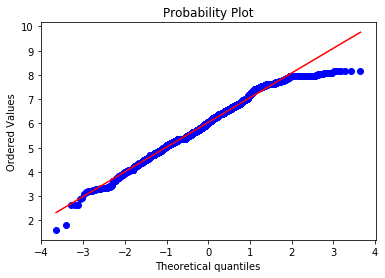


 mu = 4.90 and sigma = 0.84



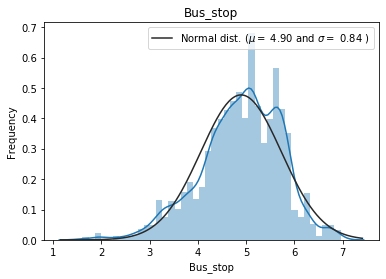

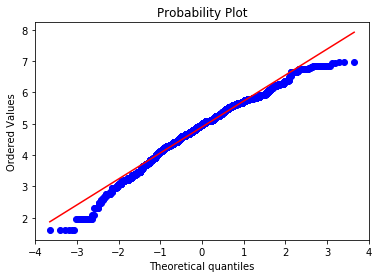


 mu = 5.40 and sigma = 1.13



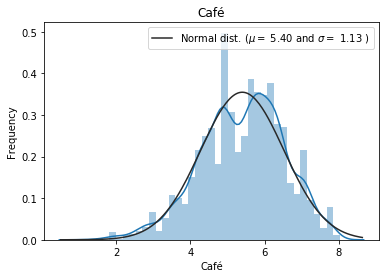

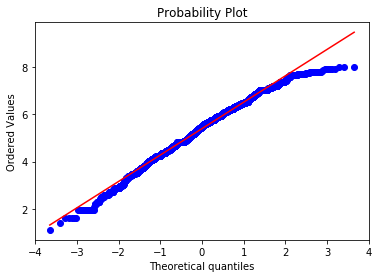


 mu = 6.63 and sigma = 0.67



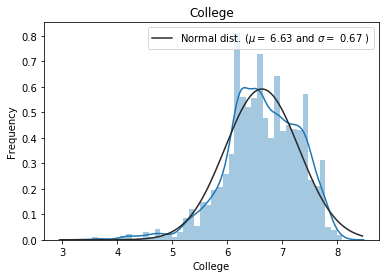

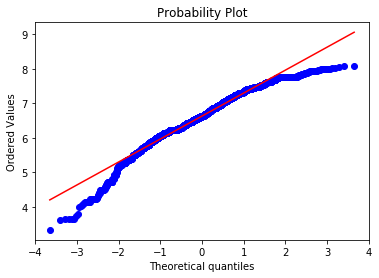


 mu = 5.86 and sigma = 0.68



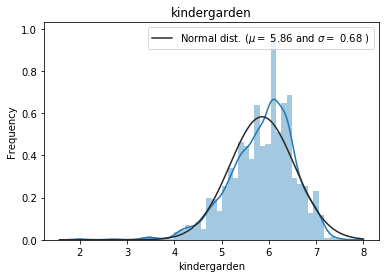

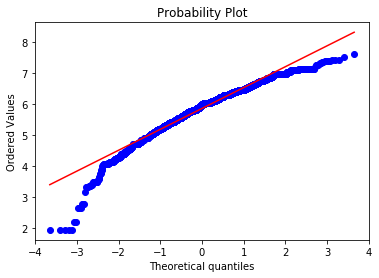


 mu = 6.82 and sigma = 0.87



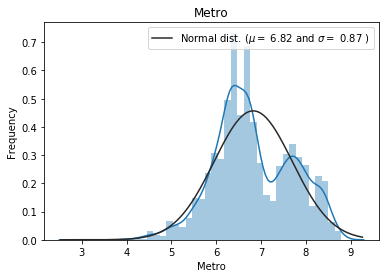

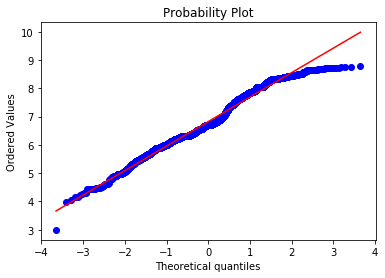


 mu = 6.40 and sigma = 1.05



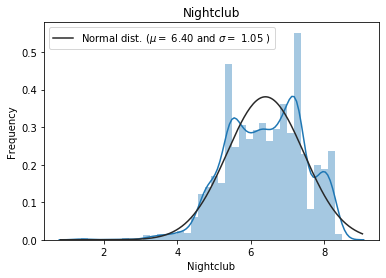

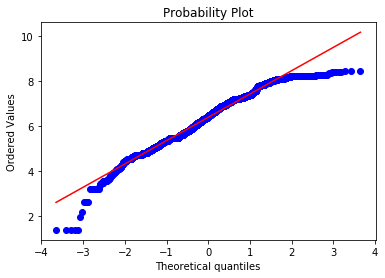


 mu = 6.52 and sigma = 1.21



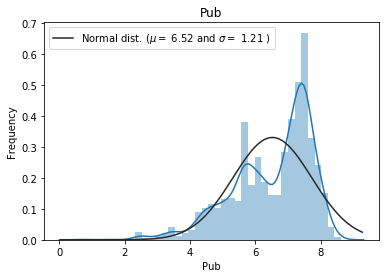

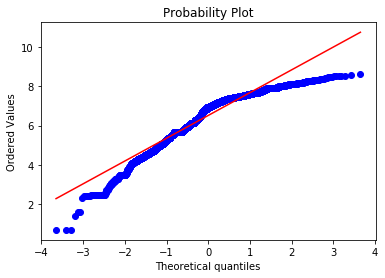


 mu = 4.96 and sigma = 1.10



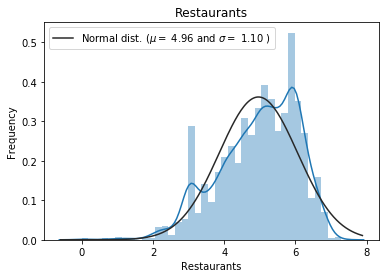

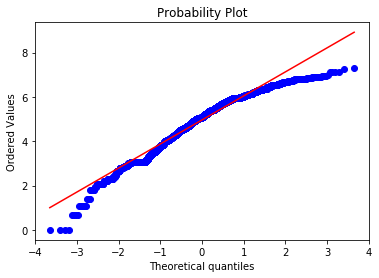


 mu = 5.52 and sigma = 0.68



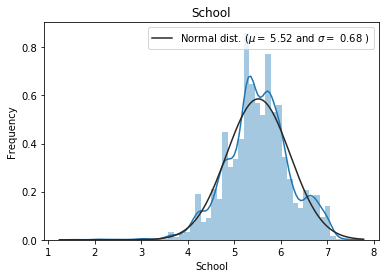

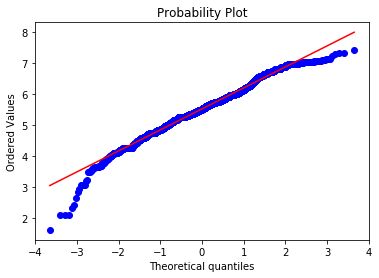


 mu = 5.45 and sigma = 0.93



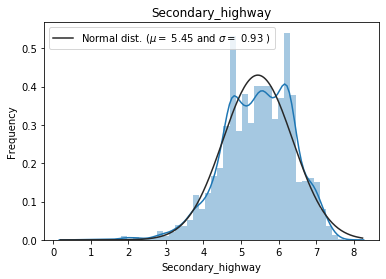

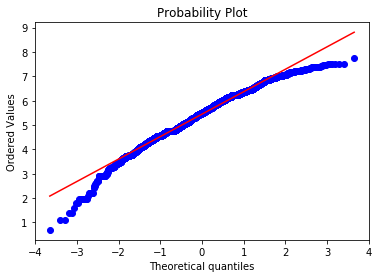


 mu = 5.13 and sigma = 0.85



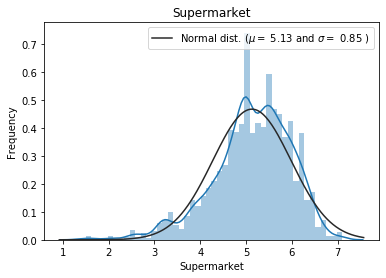

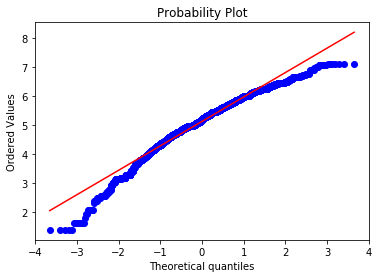


 mu = 6.37 and sigma = 0.81



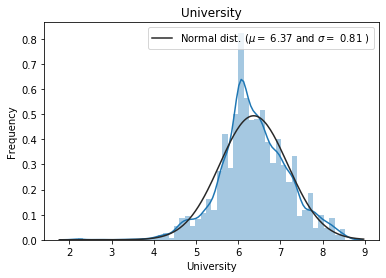

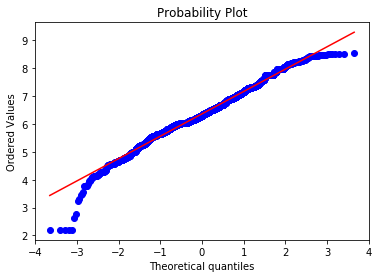


 mu = 7.49 and sigma = 0.85



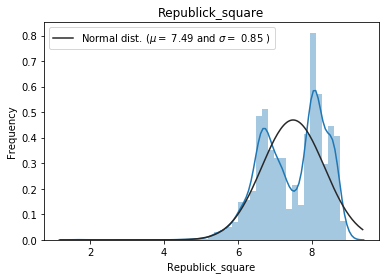

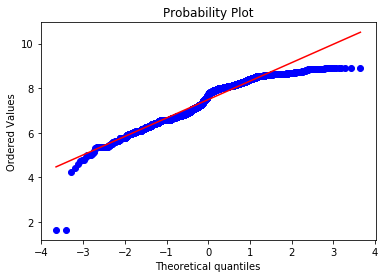


 mu = 7.39 and sigma = 0.85



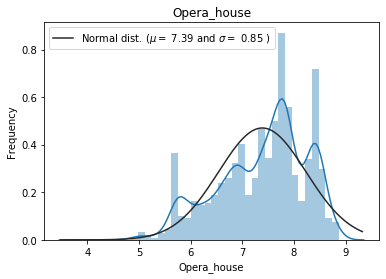

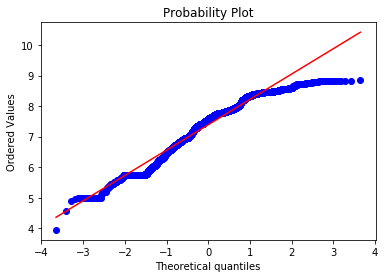

In [34]:
for i in data_numeric.columns:
    data_numeric[i] = np.log1p(data_numeric[i])

    #Check the new distribution 
    sns.distplot(data_numeric[i] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data_numeric[i])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title(i)

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data_numeric[i], plot=plt)
    plt.show()

In [37]:
len(data_numeric.columns)

25

In [38]:
len(data_object.columns)

35

In [43]:
for i in data_numeric.columns:
    data_numeric= outliers_IQR(data_numeric, i)

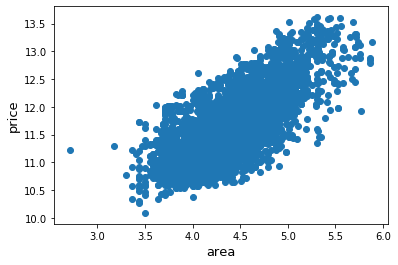

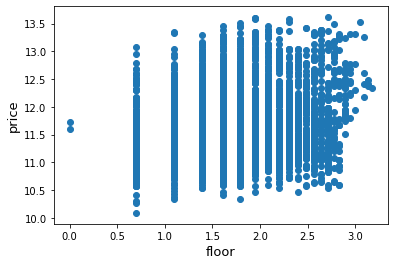

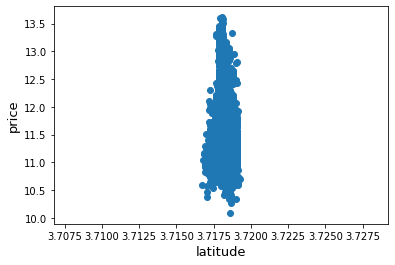

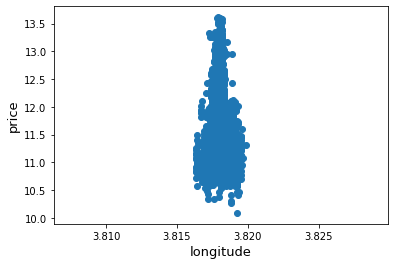

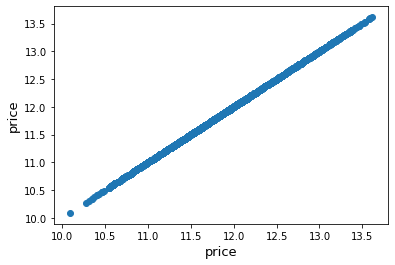

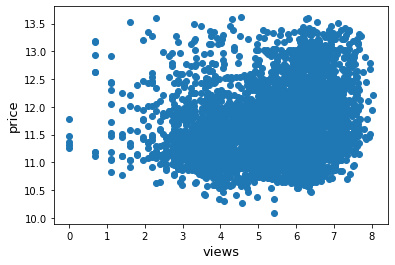

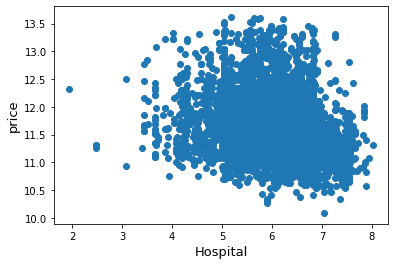

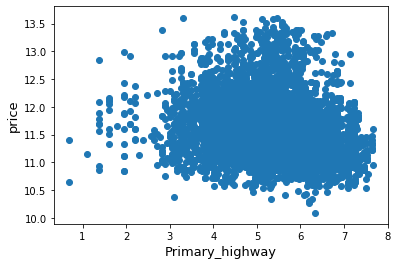

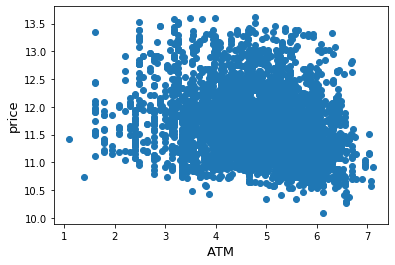

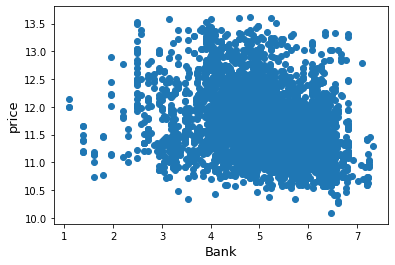

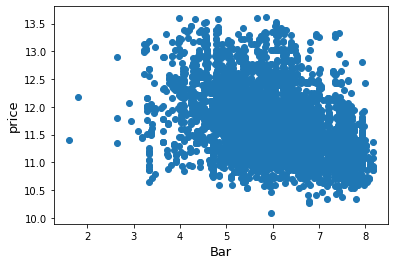

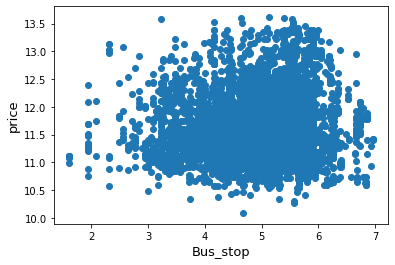

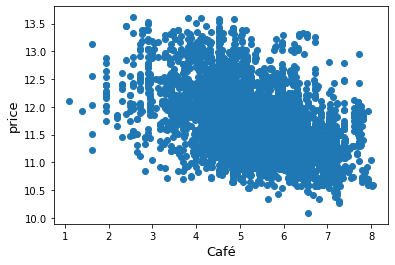

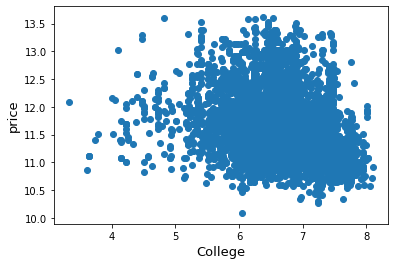

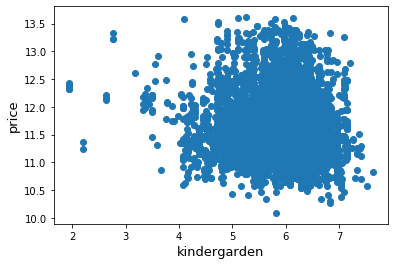

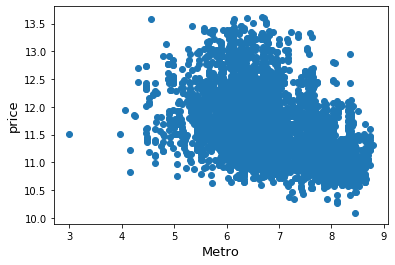

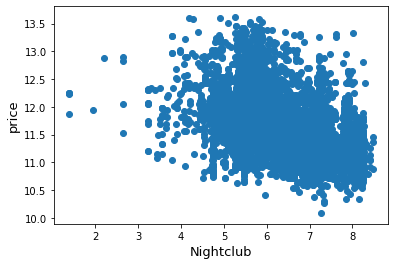

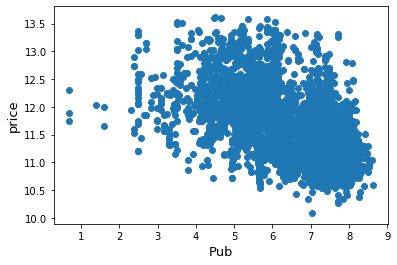

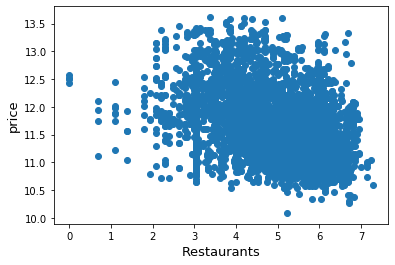

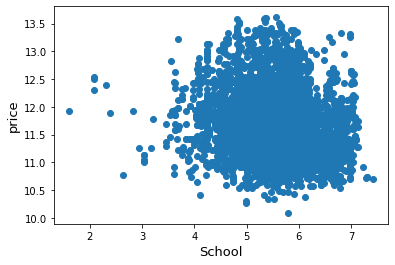

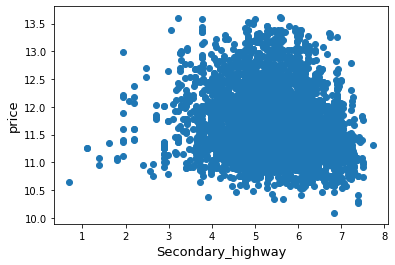

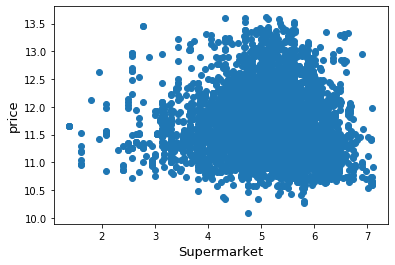

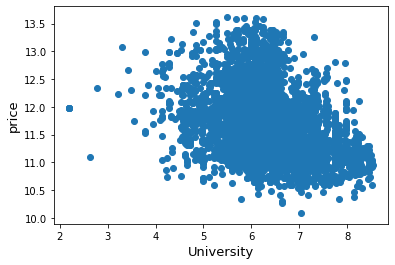

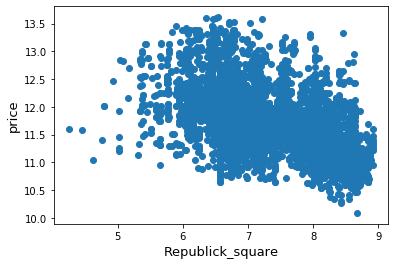

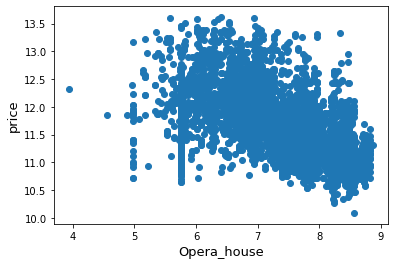

In [44]:
for i in data_numeric.columns:
    fig, ax = plt.subplots()
    ax.scatter(x = data_numeric[i], y = data_numeric['price'])
    plt.ylabel('price', fontsize=13)
    plt.xlabel(i, fontsize=13)
    plt.show()

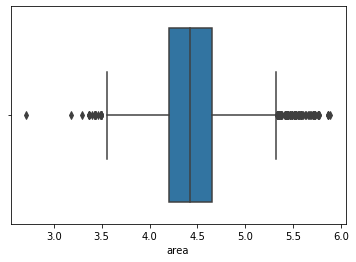

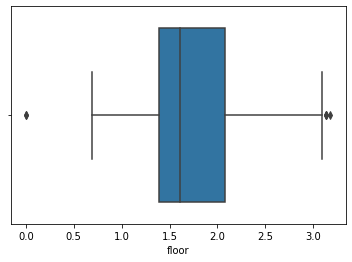

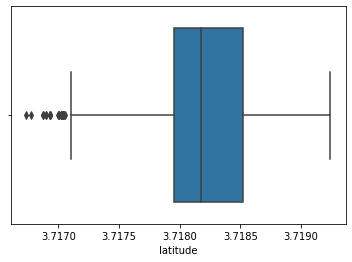

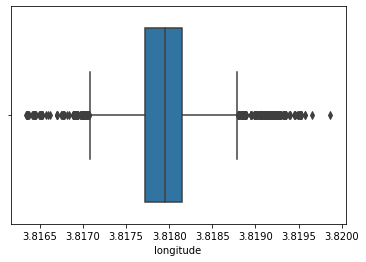

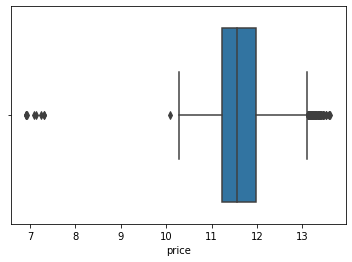

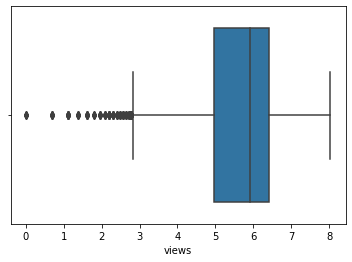

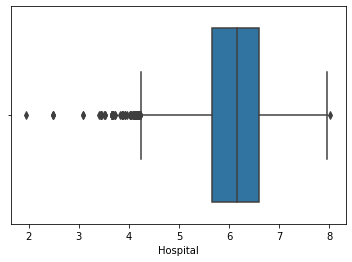

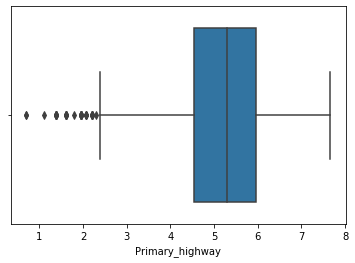

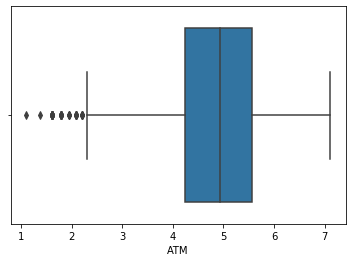

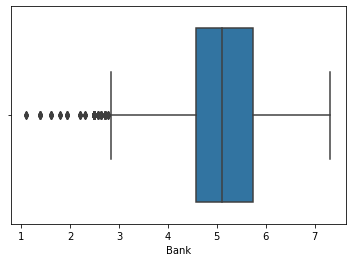

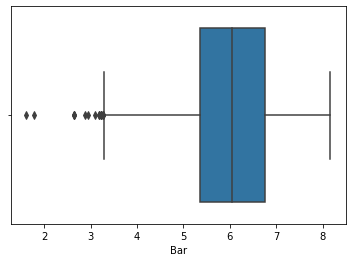

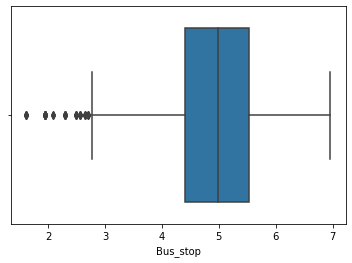

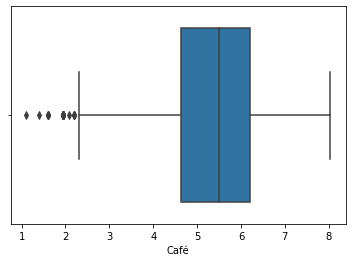

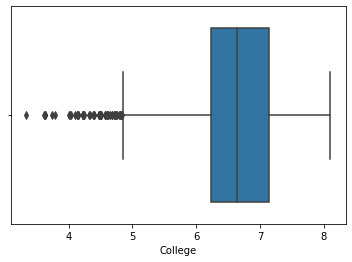

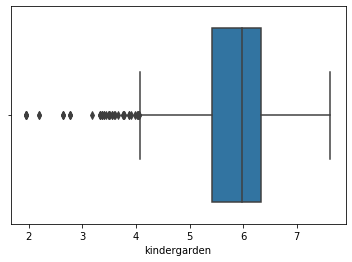

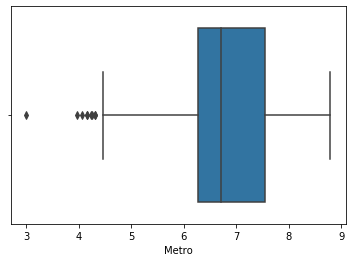

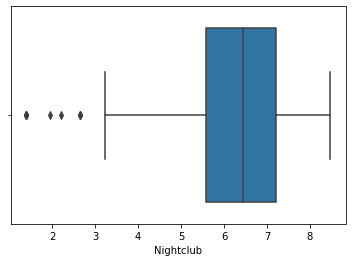

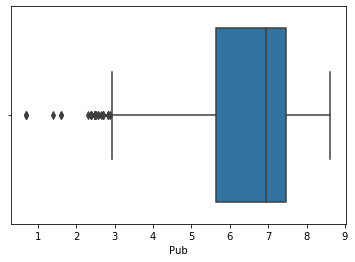

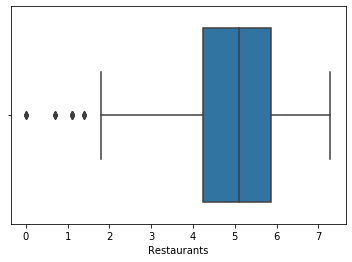

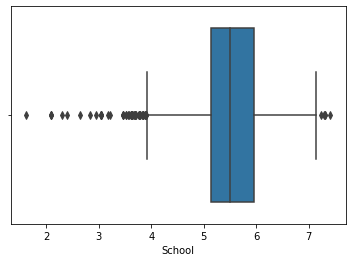

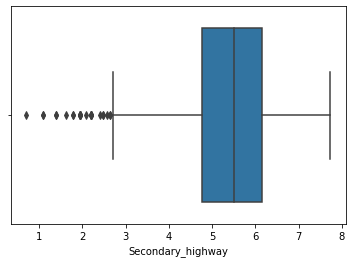

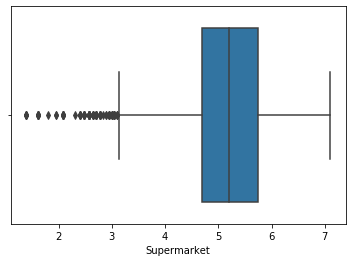

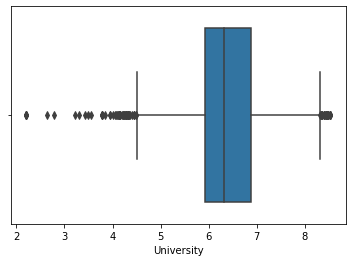

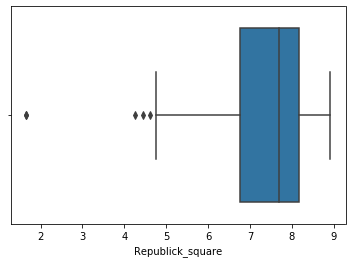

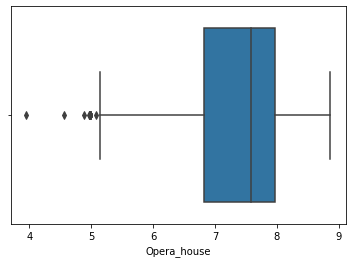

In [40]:
for i in data_numeric.columns:
    sns.boxplot(x=data_numeric[i])
    plt.show()   

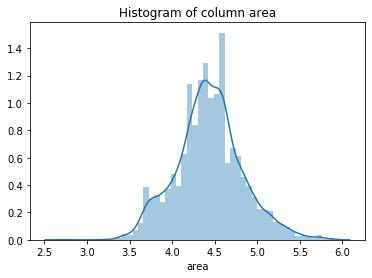

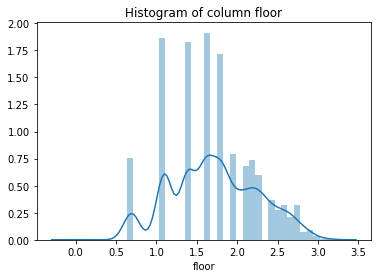

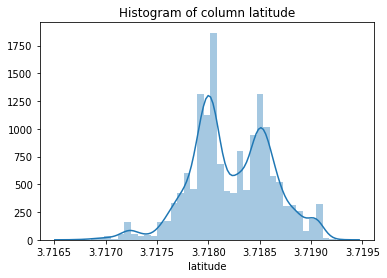

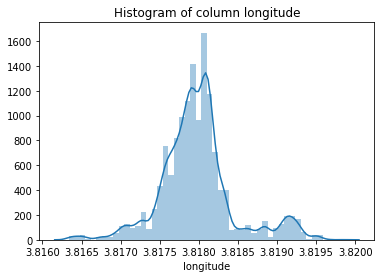

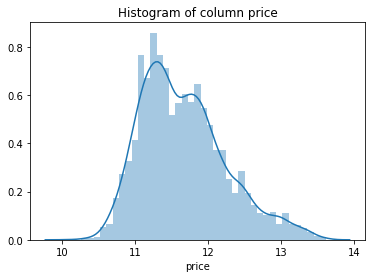

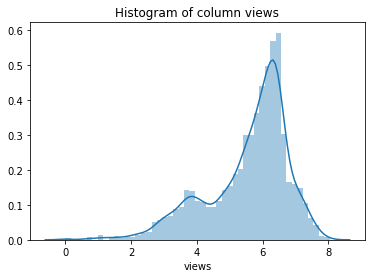

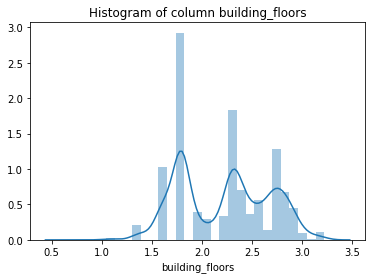

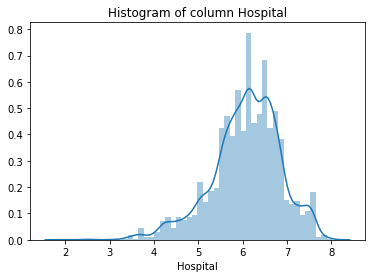

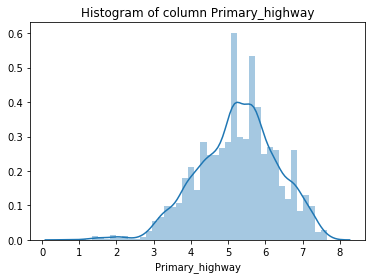

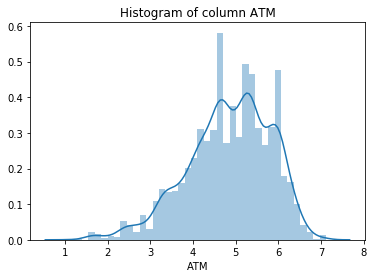

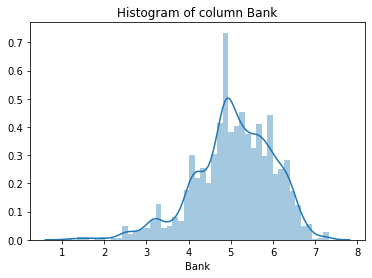

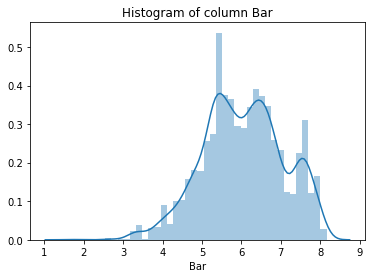

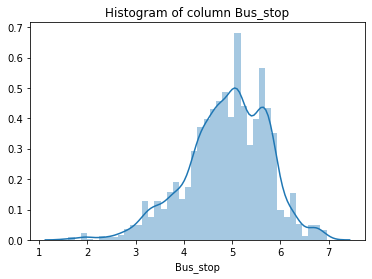

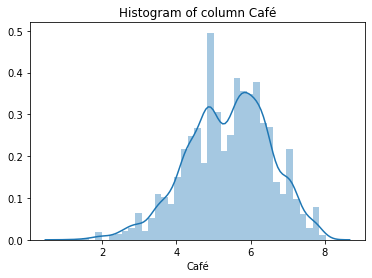

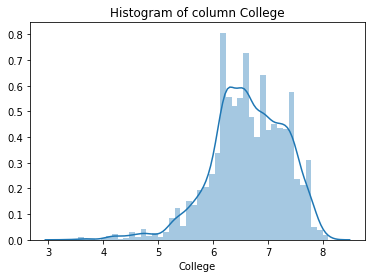

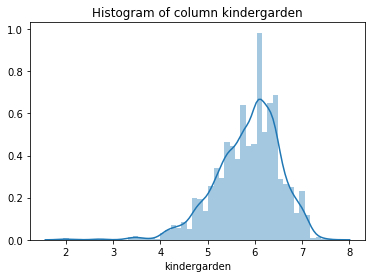

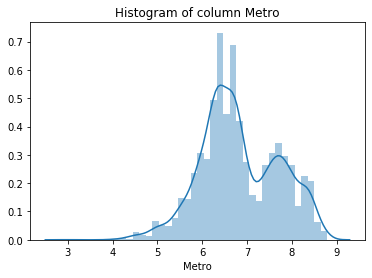

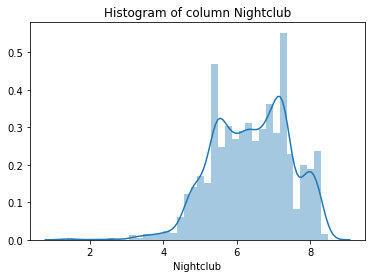

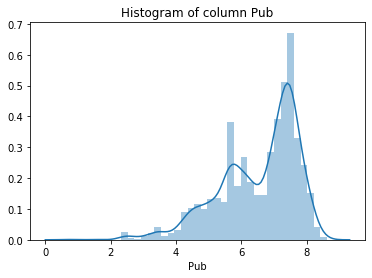

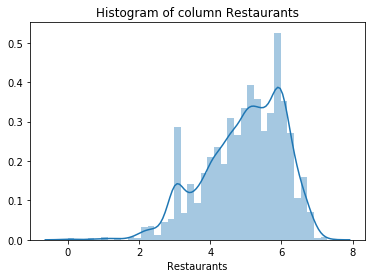

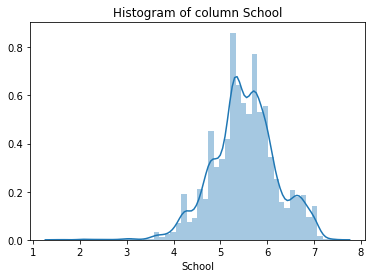

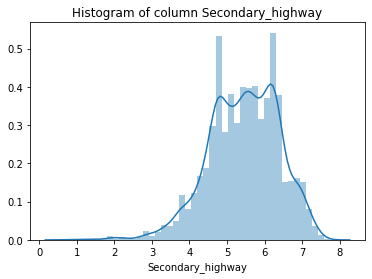

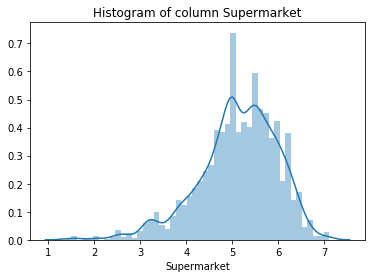

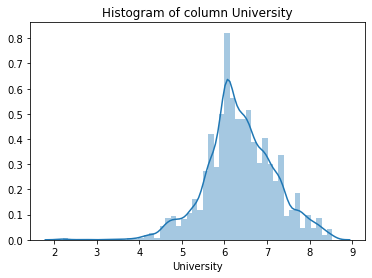

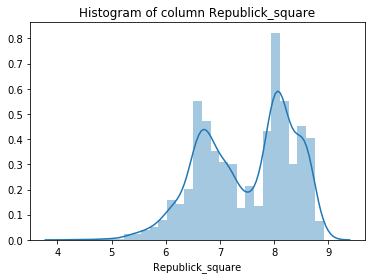

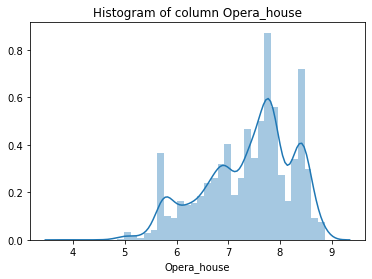

In [148]:
for i in data_numeric:
        sns.distplot(data_numeric[i],norm_hist=True)
        plt.title("Histogram of column %s"% i)
        plt.show()

In [969]:
#print(data_numeric['price'].quantile(0.90))
#data_numeric["price"] = np.where(data_numeric["price"] >12.4684369, 12.4684369,data_numeric['price'])
#print(data_numeric['price'].skew())

In [675]:
#print(data_numeric['area'].quantile(0.90))
#data_numeric["price"] = np.where(data_numeric["price"] >12.4684369, 12.4684369,data_numeric['price'])
#print(data_numeric['area'].skew())

4.941642422609304
0.4516514525485183


In [45]:
z=[]
for i in data_object.street:
    i=i.replace(" ","_")
    i=i.replace(".","_")
    i=i.replace("(","_")
    i=i.replace(")","_")
    i=i.replace("-","_")
    i=i.replace("â","_")
    i=i.replace("","_")
    i=i.replace("¤","_")
    z.append(i)

In [46]:
q=[]
for i in data_object.height:
    i=i.replace(" ","_")
    i=i.replace(".","_")
    i=i.replace("(","_")
    i=i.replace(")","_")
    i=i.replace("-","_")
    q.append(i)

In [47]:
data_object.street=z
data_object.height=q

C:\Users\arman\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [48]:
data_numeric.columns

Index(['area', 'floor', 'latitude', 'longitude', 'price', 'views', 'Hospital',
       'Primary_highway', 'ATM', 'Bank', 'Bar', 'Bus_stop', 'Café', 'College',
       'kindergarden', 'Metro', 'Nightclub', 'Pub', 'Restaurants', 'School',
       'Secondary_highway', 'Supermarket', 'University', 'Republick_square',
       'Opera_house'],
      dtype='object')

In [49]:
data_numeric.drop(["longitude","latitude"],axis=1,inplace=True) 

In [50]:
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

In [51]:
data_final=data_numeric.join(data_dummies)

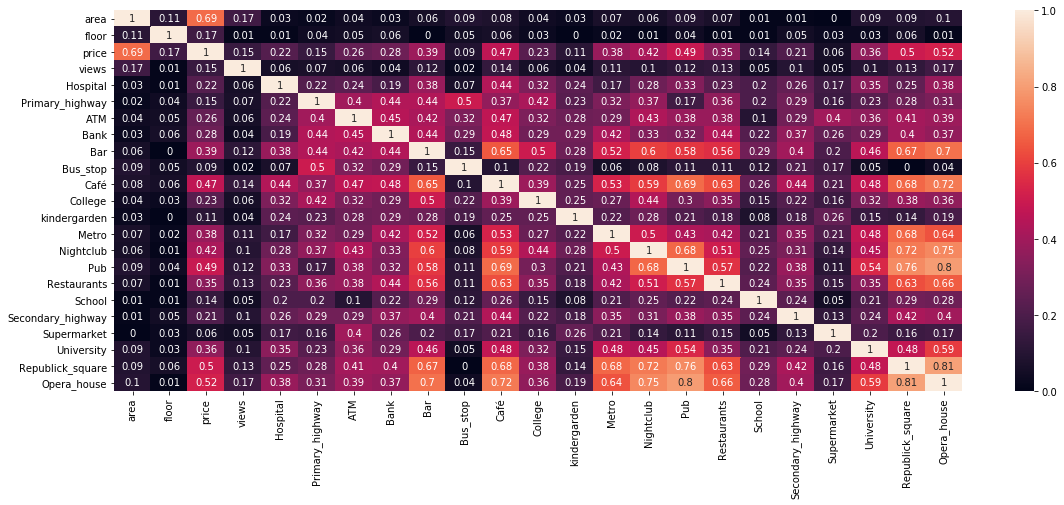

In [52]:
plt.figure(figsize=(19, 7))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [157]:
data_numeric.drop(["Opera_house",],axis=1,inplace=True)

In [53]:
from statsmodels.formula.api import ols
from scipy import stats
stats.ttest_ind(data_numeric.price[data_object.sold==1],
               data_numeric.price[data_object.sold==0])

AttributeError: 'DataFrame' object has no attribute 'sold'

In [54]:
var=data_final.columns.tolist()

In [55]:
var

['area',
 'floor',
 'price',
 'views',
 'Hospital',
 'Primary_highway',
 'ATM',
 'Bank',
 'Bar',
 'Bus_stop',
 'Café',
 'College',
 'kindergarden',
 'Metro',
 'Nightclub',
 'Pub',
 'Restaurants',
 'School',
 'Secondary_highway',
 'Supermarket',
 'University',
 'Republick_square',
 'Opera_house',
 'Air_conditioner_1',
 'Central_Heating_1',
 'Close_bus_station_1',
 'Electricity_1',
 'Equipment_1',
 'Euro_windows_1',
 'Furniture_1',
 'Gas_1',
 'Heated_Floor_1',
 'Heating_1',
 'Hot_water_1',
 'Internet_1',
 'Irrigation_1',
 'Laminate_flooring_1',
 'Open_balcony_1',
 'Parking_1',
 'Parquet_1',
 'Playground_1',
 'Security_system_1',
 'Sewerage_1',
 'Standing_water_1',
 'Sunny_1',
 'Swimming_pool_1',
 'Tile_1',
 'View_1',
 'Water_1',
 'bathrooms_1',
 'bathrooms_2',
 'bathrooms_3',
 'bathrooms_4',
 'building_type_Other',
 'building_type_Panel',
 'building_type_Stone',
 'condition_Newly_repaired',
 'condition_Zero_condition',
 'district_Arabkir',
 'district_Avan',
 'district_Center',
 'district

In [56]:
del var[2]

In [57]:
var="+".join(var)

In [58]:
formula="price~" + var

In [59]:
formula

'price~area+floor+views+Hospital+Primary_highway+ATM+Bank+Bar+Bus_stop+Café+College+kindergarden+Metro+Nightclub+Pub+Restaurants+School+Secondary_highway+Supermarket+University+Republick_square+Opera_house+Air_conditioner_1+Central_Heating_1+Close_bus_station_1+Electricity_1+Equipment_1+Euro_windows_1+Furniture_1+Gas_1+Heated_Floor_1+Heating_1+Hot_water_1+Internet_1+Irrigation_1+Laminate_flooring_1+Open_balcony_1+Parking_1+Parquet_1+Playground_1+Security_system_1+Sewerage_1+Standing_water_1+Sunny_1+Swimming_pool_1+Tile_1+View_1+Water_1+bathrooms_1+bathrooms_2+bathrooms_3+bathrooms_4+building_type_Other+building_type_Panel+building_type_Stone+condition_Newly_repaired+condition_Zero_condition+district_Arabkir+district_Avan+district_Center+district_Davtashen+district_Erebuni+district_Malatia+district_Nor+district_Norq+district_Qanaqer+district_Shengavit+district_Vahagni+height_2_8_M+height_3_2_M+height_3_8_M+height_3_M+new_construction_1+rooms_2+rooms_3+rooms_4+rooms_5+rooms_6+rooms_7+str

In [60]:
model1=ols(formula=formula,data=data_final)


In [61]:
result=model1.fit()

In [62]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     85.54
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:46:44   Log-Likelihood:                 1741.2
No. Observations:                5278   AIC:                            -2354.
Df Residuals:                    4714   BIC:                             1352.
Df Model:                         563                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   8.5333      0.285     29.908      0.000       7.974       9.093
area                                        0.7484      0.014     55.221      0.000       0.722       0.775
floor                                      -0.0147      0.007     -2.189      0.029      -0.028      -0.002
views                                      -0.0120      0.003     -4.754      0.000      -0.017      -0.007
Hospital                                    0.0135      0.007      2.022      0.043       0.000       0.026
Primary_highway                            -0.0023      0.005     -0.446      0.656      -0.013       0.008
ATM                                         0.0006      0.005      0.122      0.903      -0.008       0.010
Bank                                       -0.0190      0.005     -3.898      0.000      -0.029      -0.009
Bar                                        -0.0037      0.006     -0.606      0.545      -0.016       0.008
Bus_stop                                   -0.0150      0.005     -2.855      0.004      -0.025      -0.005
Café                                       -0.0073      0.005     -1.374      0.169      -0.018       0.003
College                                    -0.0023      0.008     -0.305      0.760      -0.017       0.012
kindergarden                               -0.0228      0.006     -3.557      0.000      -0.035      -0.010
Metro                                       0.0075      0.009      0.856      0.392      -0.010       0.025
Nightclub                                  -0.0043      0.007     -0.617      0.537      -0.018       0.009
Pub                                        -0.0057      0.007     -0.780      0.436      -0.020       0.009
Restaurants                                 0.0035      0.005      0.769      0.442      -0.005       0.013
School                                     -0.0124      0.006     -2.218      0.027      -0.023      -0.001
Secondary_highway                          -0.0027      0.005     -0.542      0.588      -0.013       0.007
Supermarket                                 0.0137      0.005      2.815      0.005       0.004       0.023
University                                 -0.0073      0.007     -0.981      0.326      -0.022       0.007
Republick_square                           -0.0055      0.013     -0.416      0.677      -0.031       0.020
Opera_house                                -0.0152      0.011     -1.419      0.156      -0.036       0.006
Air_conditioner_1                           0.0351      0.008      4.291      0.000       0.019       0.051
Central_Heating_1                           0.0276      0.009      3.060      0.002       0.010       0.045
Close_bus_station_1                        -0.0325      0.0

In [63]:
train,test=train_test_split(data_final,test_size=0.25,random_state=42)

In [64]:
model2=ols(formula=formula,data=train).fit()
pred=model2.predict(test)

In [65]:
r2=r2_score(test.price,pred)
r2

0.8787961512650337

In [67]:
#gather features
#features = "+".join(data_final.columns - ["price"])

# get y and X dataframes based on this regression:
y, X = dmatrices(formula, data_final, return_type='dataframe')

NameError: name 'dmatrices' is not defined

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [ ]:
vif.round(1)

##### Linear regression results are r2   0.87

### Data spliting for tarin and test sets

In [171]:
X=data_final.drop("price",axis=1)
Y=data_final.price
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Generalized Linear Model

In [172]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

X = sm.add_constant(X)

# Instantiate a gamma family model with the default link function.
gamma_model = sm.GLM(Y, X, family=sm.families.Gamma())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

C:\Users\arman\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
C:\Users\arman\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\arman\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\arman\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\arman\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 5278
Model:                            GLM   Df Residuals:                     4735
Model Family:                   Gamma   Df Model:                          542
Link Function:          inverse_power   Scale:                      0.00024190
Method:                          IRLS   Log-Likelihood:                 1807.9
Date:                Wed, 29 Jul 2020   Deviance:                       1.1422
Time:                        02:36:18   Pearson chi2:                     1.15
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

### Random Forest Regressor

In [186]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth = 5, random_state = 42, n_estimators = 100)
regr.fit(x_train, y_train)

default_importance = regr.feature_importances_

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(regr, x_train, y_train)

In [193]:
y_pred=regr.predict(x_test)
evaluation(y_test,y_pred)

(0.26, 1.71)

#### LASSO Regression

In [1008]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#### Elastic Net

In [1009]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### Kernel Ridge Regression :

In [1010]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### Gradient Boosting Regression :
#### With huber loss that makes it robust to outliers

In [1011]:
GBoost = GradientBoostingRegressor()

#### XGBoost :


In [1013]:
model_xgb = xgb.XGBRegressor()

#### LightGBM 

In [1071]:
model_lgb = lgb.LGBMRegressor(objective='regression')

In [1068]:
model_xgb.fit(x_train, y_train)
xgb_train_pred = model_xgb.predict(x_train)
xgb_pred = np.expm1(model_xgb.predict(x_test))
print(evaluation(y_train, xgb_train_pred))

[23:14:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.02060367268882302


In [1038]:
regressor=xgboost.XGBRegressor()

In [1039]:
n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=["gbtree","gblinear"]
learning_rate=[0.05,0.1,0.15,0.2]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

In [1040]:
hyperparameter_grid={
    "n_estimators" : n_estimators,
    "max_depth" : max_depth,
    "learning_rate" : learning_rate,
    "min_child_weight" : min_child_weight,
    "booster" : booster,
    "base_score":base_score
}

In [1043]:
from sklearn.model_selection import RandomizedSearchCV
random_cv=RandomizedSearchCV(estimator=regressor,
                            param_distributions=hyperparameter_grid,
                            cv=5,n_iter=50,
                            n_jobs=4,
                            verbose=5,
                            return_train_score=True,
                            random_state=42)

In [1044]:
random_cv.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 210.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 232.5min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 262.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          verbosity=None),
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1

In [1046]:
random_cv.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [1049]:
regressor=xgboost.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=4,  monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [1050]:
regressor.fit(x_train,y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [1051]:
y_pred=regressor.predict(x_test)

In [1055]:
r2_score(y_test,y_pred)

0.8963516856859961

In [1057]:
evaluation(y_test,y_pred) # RMSE = 0.01

(0.01, 0.4)